In [59]:
import numpy as np
import pandas as pd
import torch
import os
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
from bayesreconpy.reconc_buis import reconc_buis
from utils import (
    import_raw_data, 
    make_dataloaders,
    optimal_forecast,
    save_forecasts
)
from reconciliation import (
    make_imputed_data,
    temporal_recon_ts,
    hierarchical_data
)
from forecasters import gp 

In [85]:
torch.manual_seed(42)
np.random.seed(42)

<Axes: ylabel='Store-Product'>

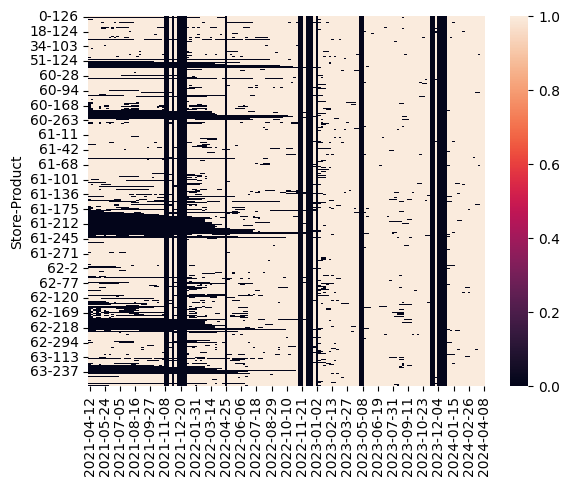

In [86]:
sales, in_stock, master = import_raw_data()
in_stock = in_stock.iloc[:, :157]
colmeans = np.nanmean(np.where(in_stock, sales, np.nan), axis=0)
in_stock.iloc[:, colmeans > 4.] = False

#sales_imputed, in_stock_imputed, imputed_idx, _ = make_imputed_data(sales, in_stock, hot_start = True)
sns.heatmap(in_stock)

In [87]:
def negbingp(train_y, train_x, test_x):
    return gp(train_y, train_x, test_x, likelihood="negbin", kernel=None)

def recon_negbingp(train_y, observed, h):
    recon_samples, _ = temporal_recon_ts(negbingp, train_y, observed, 3)
    return recon_samples[:,:h]

In [88]:
_, _, _, competition_loader = make_dataloaders((sales, in_stock, master), 157, 3, batch_size=1)

forecasts = []

for i, ts in tqdm(enumerate(competition_loader)):

    train_y, test_y = ts['past_target'].squeeze(), ts['future_target'].squeeze()
    observed = ts['past_observed_values'].squeeze()

    samples = recon_negbingp(train_y, observed, 3)

    forecasts.append(samples[None,:,:3])

forecasts = np.vstack(forecasts)
        

599it [06:38,  1.50it/s]


In [91]:
solution = []

initial_state = pd.read_csv(os.path.join("data", "Week 0 - 2024-04-08 - Initial State.csv"))
assert len(forecasts) == len(initial_state)

for i in range(len(forecasts)):
    s0, w1, w2 = initial_state.loc[i, ["End Inventory", "In Transit W+1", "In Transit W+2"]].values
    opt = optimal_forecast(forecasts[i], s0, w1, w2)
    solution.append(opt.item())


solution = np.array(solution)

In [92]:
initial_state = pd.read_csv(os.path.join("data", "Week 0 - 2024-04-08 - Initial State.csv"))
for i in range(10):
    s0, w1, w2 = initial_state.loc[i, ["End Inventory", "In Transit W+1", "In Transit W+2"]].values
    print(s0, w1, w2)

3 0 3
1 0 1
6 0 6
9 0 7
3 0 1
4 0 2
11 0 10
2 0 1
4 0 4
7 0 7


In [93]:

# save the forecasts into a csv
def save_forecasts(forecast_samples: np.ndarray):

    sales, in_stock, _ = import_raw_data()
    forecast_df = pd.DataFrame(forecast_samples, index=sales.index).astype(int)
    forecast_df.to_csv("solution base" +datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".csv")

save_forecasts(solution)

## Recon submission

100%|██████████| 599/599 [03:19<00:00,  3.01it/s]


<Axes: ylabel='None-None'>

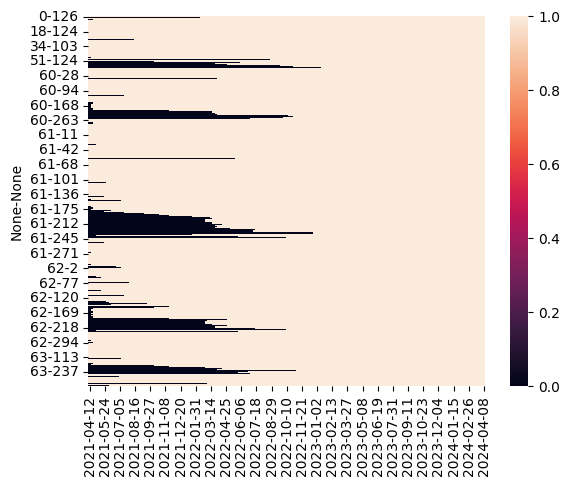

In [70]:
sales, in_stock, master = import_raw_data()
in_stock = in_stock.iloc[:, :157]
colmeans = np.nanmean(np.where(in_stock, sales, np.nan), axis=0)
in_stock.iloc[:, colmeans > 4.] = False

sales_imputed, in_stock_imputed, imputed_idx, _ = make_imputed_data(sales, in_stock, hot_start = True)
sns.heatmap(in_stock_imputed)

<Axes: >

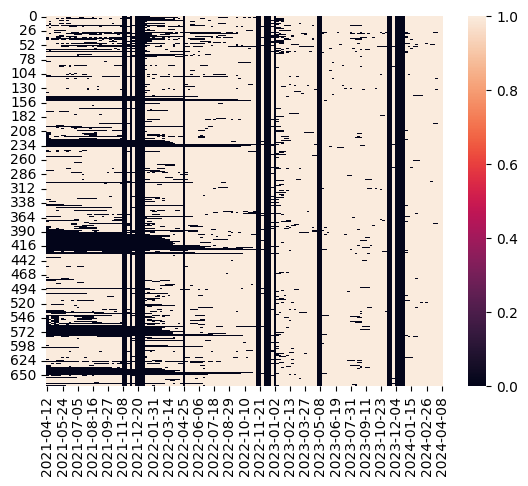

In [73]:
A = pd.read_csv("A_product_same_order_as_sales.csv")
A = np.array(A.set_index(A.columns[0]))

sales_aggr, in_stock_aggr, master_aggr = hierarchical_data(sales_imputed, in_stock_imputed, master, A,
                                                               imputed_idx, 0.1)

merged_datasets = [
    pd.concat([
        aggr.set_index(aggr.index.to_flat_index()),
        data.set_index(data.index.to_flat_index())
        ], 
        axis=0).reset_index(drop=True)
        for data, aggr in zip(
            [sales, in_stock, master],
            [sales_aggr, in_stock_aggr, master_aggr]
            )
]

sns.heatmap(merged_datasets[1].iloc[:,:157])

In [ ]:
def negbingp(train_y, train_x, test_x):
    return gp(train_y, train_x, test_x, likelihood="negbin", kernel=None)

def recon_negbingp(train_y, observed, h):
    recon_samples, _ = temporal_recon_ts(negbingp, train_y, observed, 3)
    return recon_samples[:,:h]

def exactgp(train_y, train_x, test_x):
    return gp(train_y, train_x, test_x, likelihood="gaussian", kernel=None)

def recon_exactgp(train_y, observed, h):
    recon_samples, _ = temporal_recon_ts(exactgp, train_y, observed, 3)
    return recon_samples[:,:h]


In [ ]:
_, _, _, competition_loader = make_dataloaders(merged_datasets, 157, 3, batch_size=1)

hier_forecasts = []

# iterate over t.s. of the dataset
for i, ts in tqdm(enumerate(competition_loader)):

    if i < len(A):
        fn = recon_exactgp
    else:
        fn = recon_negbingp

    # select the values and provide base forecasts
    train_y, test_y = ts['past_target'].squeeze(), ts['future_target'].squeeze()
    observed = ts['past_observed_values'].squeeze()
    samples = fn(train_y, observed, 3)
    
    # include observed values and samples
    hier_forecasts.append(samples[None,:,:3])

# stack together previously computed values
hier_forecasts = np.vstack(hier_forecasts)
print(hier_forecasts.shape)

670it [07:11,  1.55it/s]


In [82]:
reconciled_forecasts = []
n_base = len(hier_forecasts)
for hor in range(3):
    bottom_samples = reconc_buis(A=A, 
        base_forecasts=[hier_forecasts[ns,:,hor] for ns in range(n_base)],
        in_type=["samples"]*n_base,
        distr='discrete', 
        num_samples=hier_forecasts.shape[1])['bottom_reconciled_samples']
    reconciled_forecasts.append(bottom_samples)

# aggregate reconciled samples and compute the quantile loss
reconciled_forecasts = np.dstack(reconciled_forecasts)
print(reconciled_forecasts.shape)




(599, 100000, 3)


In [83]:
solution = []

initial_state = pd.read_csv(os.path.join("data", "Week 0 - 2024-04-08 - Initial State.csv"))
assert len(reconciled_forecasts) == len(initial_state)

for i in range(len(reconciled_forecasts)):
    s0, w1, w2 = initial_state.loc[i, ["End Inventory", "In Transit W+1", "In Transit W+2"]].values
    opt = optimal_forecast(reconciled_forecasts[i], s0, w1, w2)
    solution.append(opt.item())


solution = np.array(solution)

In [84]:
# save the forecasts into a csv
def save_forecasts(forecast_samples: np.ndarray):

    sales, in_stock, _ = import_raw_data()
    forecast_df = pd.DataFrame(forecast_samples, index=sales.index).astype(int)
    forecast_df.to_csv("solution recon " +datetime.now().strftime("%Y-%m-%d %H-%M-%S") + ".csv")

save_forecasts(solution)

## Other

201
133


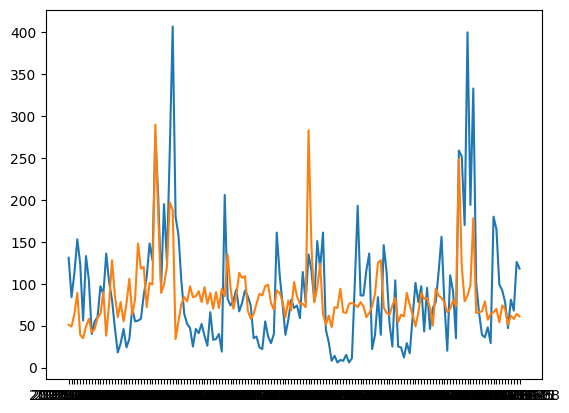

In [108]:
sub1 = pd.read_csv("solution 2025-10-21 10:53:08.csv")["0"].values
sub2 = pd.read_csv("solution base2025-10-21 23-05-56.csv")["0"].values

print(np.argmin(sub1- sub2))
print(np.argmax(sub1- sub2))

import matplotlib.pyplot as plt
plt.plot(sales.iloc[201])
plt.plot(sales.iloc[133])

277
41
-43 1


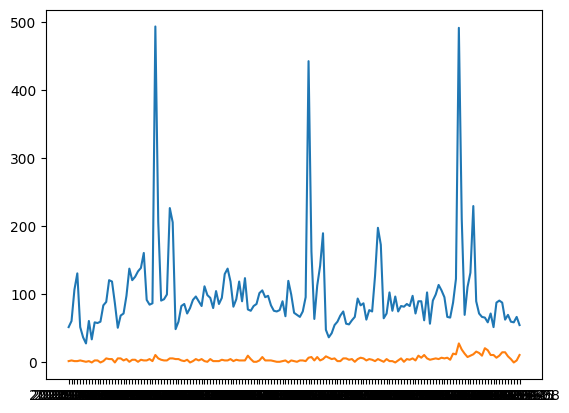

In [115]:
sub3 = pd.read_csv("solution recon 2025-10-21 22-55-45.csv")["0"].values

print(np.argmin(sub2- sub3))
print(np.argmax(sub2- sub3))
print(np.min(sub2- sub3), np.max(sub2- sub3))


import matplotlib.pyplot as plt
plt.plot(sales.iloc[277])
plt.plot(sales.iloc[41])